In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets , transforms
import torch.optim as optim
from torchvision.transforms import ToTensor
from torchvision.datasets import EuroSAT 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([ToTensor(),
                                transforms.Normalize((0.5 , 0.5 , 0.5),(0.5,0.5,0.5)),])
trainset = datasets.CIFAR10(root='./data' , download = True , train = True , transform = transform,)
trainloader = torch.utils.data.DataLoader(trainset , shuffle = True , batch_size = 16)
testset = datasets.CIFAR10(root='./data' , download = True , train = False , transform = transform)
testloader = torch.utils.data.DataLoader(testset , shuffle = True , batch_size = 16)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


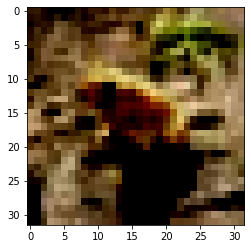

In [4]:
index = 6000
img , label = trainset[index]
img = img.permute(1 , 2 , 0) 
plt.imshow(img)
plt.show()

In [ ]:
# rgb data (3 ,32 ,32)
# 60,000 examples
# 10 classes

In [24]:
class Convnet(nn.Module):
  def __init__(self , lr , batch_size , classes , epochs):
    super(Convnet , self).__init__()
    self.lr = lr
    self.batch_size = batch_size
    self.classes = classes
    self.epochs = epochs
    self.loss_history = []
    self.acc_history = []
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.conv1 = nn.Conv2d(3 , 6 , 3 , stride = 1 , padding = 1)
    self.batch1 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(6 , 16 , 3, stride = 1 , padding = 1)
    self.batch2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16 , 32 , 3, stride = 1 , padding = 1)
    self.batch3 = nn.BatchNorm2d(32)
    self.maxpool1 = nn.MaxPool2d((2,2))
    self.conv4 = nn.Conv2d(32 , 64 , 3, stride = 1 , padding = 1)
    self.batch4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64 , 128 , 3, stride = 1 , padding = 1)
    self.batch5 = nn.BatchNorm2d(128)
    self.maxpool2 = nn.MaxPool2d((3,3))
    self.flatten = nn.Flatten()
    input_dims = self.calc_input_dims()
    self.fc1 = nn.Linear(input_dims , 64)
    self.fc2 = nn.Linear(64 , 32) 
    self.fc3 = nn.Linear(32 , 10)
    
    self.optimizer = optim.Adam(self.parameters() , lr = self.lr)
    self.loss = nn.CrossEntropyLoss()
    self.to(self.device)
    self.load_data()
  def calc_input_dims(self):
    data = torch.zeros((3 , 32 , 32))
    data = self.conv1(data)
    data = self.conv2(data)
    data = self.conv3(data)
    data = self.maxpool1(data)
    data = self.conv4(data)
    data = self.conv5(data)
    data = self.maxpool2(data)
    return int(np.product(data.size()))

  def load_data(self):
    transform = transforms.Compose([ToTensor(),
                                transforms.Normalize((0.5 , 0.5 , 0.5),(0.5,0.5,0.5)),])
    trainset = datasets.CIFAR10(root='./data' , download = True , train = True , transform = transform,)
    self.trainloader = torch.utils.data.DataLoader(trainset , shuffle = True , 
                                                   batch_size = self.batch_size ,
                                                   num_workers = 4)
    testset = datasets.CIFAR10(root='./data' , download = True , train = False , transform = transform)
    self.testloader = torch.utils.data.DataLoader(testset , shuffle = True ,
                                                  batch_size = self.batch_size ,
                                                  num_workers = 4)
  def forward(self , x):
    x = self.conv1(x)
    x = f.relu(x)
    x = self.batch1(x)
    x = self.conv2(x)
    x = f.relu(x)
    x = self.batch2(x)
    x = self.conv3(x)
    x = f.relu(x)
    x = self.batch3(x)
    x = self.maxpool1(x)
    x = self.conv4(x)
    x = f.relu(x)
    x = self.batch4(x)
    x = self.conv5(x)
    x = f.relu(x)
    x = self.batch5(x)
    x = self.maxpool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    classes = self.fc3(x)
    return classes
  def traindata(self):
    self.train()
    for i in range(self.epochs):
        ep_loss = 0 
        ep_acc = []
        for j , (img , label) in enumerate(self.trainloader)  :
            label = label.to(self.device)
            self.optimizer.zero_grad()
            predictions = self.forward(img)
            loss = self.loss(predictions , label)
            predictions = f.softmax(predictions , dim = 1)
            classes = torch.argmax(predictions , dim =1)
            wrong = torch.where(classes!=label , 
                                torch.tensor([1.]).to(self.device),
                                torch.tensor([0.]).to(self.device))
            acc = 1 - (torch.sum(wrong) / self.batch_size)
            self.loss_history.append(loss.item())
            ep_acc.append(acc.item())
            ep_loss += loss.item()
            loss.backward()
            self.optimizer.step() 
        self.acc_history.append(ep_acc)

        print('finish epoch' , i , 'total loss %.3f' %ep_loss,
              'accuracy %.3f' %np.mean(ep_acc))
  def testdata(self):
      self.test()
      for i in range(self.epochs):
          for j , (img , label) in enumerate(self.testloader):
              ep_loss = 0 
              ep_acc = []
              label = label.to(self.device)
              predictions = self.forward(img)
              loss = self.loss(predictions , label)
              predictions = f.softmax(predictions , dim = 1)
              classes = torch.argmax(predictions , dim =1)
              wrong = torch.where(classes!=label , 
                                  torch.tensor([1.]).to(self.device),
                                  torch.tensor([0.]).to(self.device))
              acc = 1 - (torch.sum(wrong) / self.batch_size)
              self.loss_history.append(loss.item())
              ep_acc.append(acc.item())
              ep_loss += loss.item()
              self.acc_history.append(ep_acc)
          print('finish epoch' , i , 'total loss %.3f' %ep_loss,
                'accuracy %.3f' %np.mean(ep_acc))

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
finish epoch 0 total loss 6066.271 accuracy 0.572
finish epoch 1 total loss 3999.995 accuracy 0.720


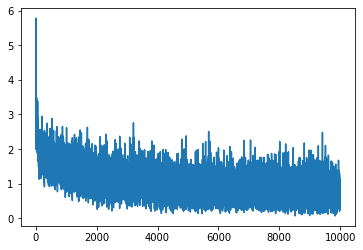

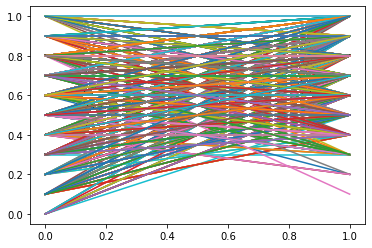

In [25]:
net = Convnet(lr = 0.001 , batch_size = 10 , classes = 10 , epochs = 2)
net.traindata()
plt.plot(net.loss_history)
plt.show()
plt.plot(np.mean(net.ep_acc))
plt.show()